In [194]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [195]:
# Create Dataset
train_dataset = dataset.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = dataset.MNIST(root='./data', download=True, transform=transforms.ToTensor())

In [196]:
trainloader = DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validloader = DataLoader(dataset=valid_dataset, batch_size=5000, shuffle=False)

In [197]:
# Create Module with Batch Normalization
class ANN_BN(nn.Module):
  def __init__(self, Layers):
    super(ANN_BN, self).__init__()
    self.hidden = nn.ModuleList()
    self.batch_normal = nn.ModuleList()
    for input_dim, output_dim in zip(Layers, Layers[1:]):
      linear = nn.Linear(input_dim, output_dim)
      self.hidden.append(linear)
      bn = nn.BatchNorm1d(output_dim)    # Batch Normalization
      self.batch_normal.append(bn)

  def forward(self, x):
    L = len(self.hidden)
    for i,linear,batch_normal in zip(range(L), self.hidden, self.batch_normal):
      if i < L-1:
        x = torch.sigmoid(linear(x))
        x = batch_normal(x)
      else:
        x = linear(x)
    return x

  def output_hidden(self, x):
    out = []
    L = len(self.hidden)
    for i,linear,batch_normal in zip(range(L), self.hidden, self.batch_normal):
      if i < L-1:
        x = torch.sigmoid(linear(x))
        x = batch_normal(x)
        out.append(x.detach().tolist())
      else:
        x = linear(x)
        out.append(x.detach().tolist())
    return out


# Create Module Non-Batch Normalization
class ANN(nn.Module):
  def __init__(self, Layers):
    super(ANN, self).__init__()
    self.hidden = nn.ModuleList()
    for input_dim, output_dim in zip(Layers, Layers[1:]):
      linear = nn.Linear(input_dim, output_dim)
      self.hidden.append(linear)


  def forward(self, x):
      L = len(self.hidden)
      for i,linear in zip(range(L), self.hidden):
        if i < L-1:
          x = torch.sigmoid(linear(x))
        else:
          x = linear(x)
      return x

  def output_hidden(self, x):
    out = []
    L = len(self.hidden)
    for i,linear in zip(range(L), self.hidden):
      if i < L-1:
        x = torch.sigmoid(linear(x))
        out.append(x.detach().tolist())
      else:
        x = linear(x)
        out.append(x.detach().tolist())
    return out

# Loss Function
criterion = nn.CrossEntropyLoss()

In [198]:
COST = {'Batch Normalization': [], 'Non': []}
ACC = {'Batch Normalization': [], 'Non': []}
def training(model, epochs, optimizer, method_name):
  for epoch in range(epochs):
    total_loss = 0
    for x,y in trainloader:
      yhat = model(x.view(-1, 28*28))
      loss = criterion(yhat, y)
      total_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    COST[method_name].append(total_loss)


    model_bn.eval()
    correct = 0
    for x,y in validloader:
      z = model(x.view(-1, 28*28))
      __,label = torch.max(z, 1)
      correct += (label == y).sum().item()
    ACC[method_name].append(correct / len(valid_dataset))
    model_bn.train()

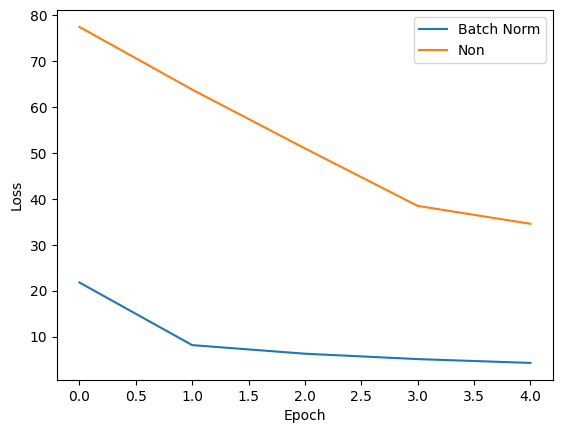

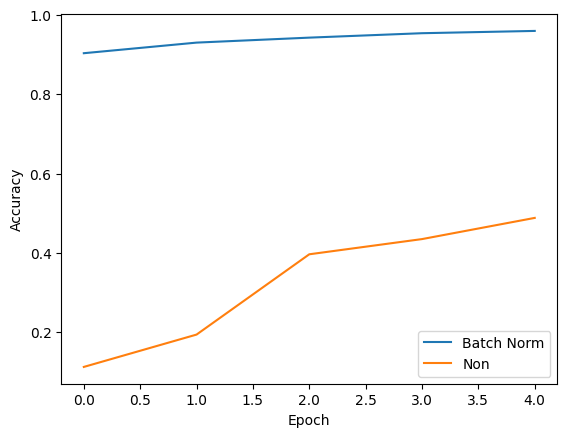

In [199]:
input_dim = 28 * 28
output_dim = 10
Layers = [input_dim, 100, 100, output_dim]
COST = {'Batch Normalization': [], 'Non': []}
ACC = {'Batch Normalization': [], 'Non': []}

model_bn = ANN_BN(Layers)
model_bn.train()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.1)
training(model_bn, epochs=5, optimizer=optimizer_bn, method_name='Batch Normalization')

model = ANN(Layers)
optimizer = optim.Adam(model.parameters(), lr=0.1)
training(model, epochs=5, optimizer=optimizer, method_name='Non')

# Show Result
plt.plot(COST['Batch Normalization'], label='Batch Norm')
plt.plot(COST['Non'], label='Non')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Show Result
plt.plot(ACC['Batch Normalization'], label='Batch Norm')
plt.plot(ACC['Non'], label='Non')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

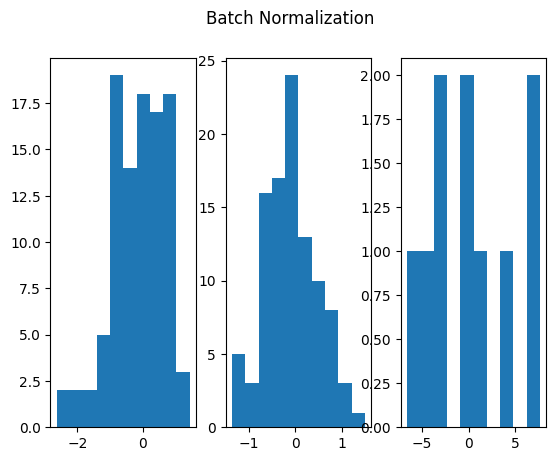

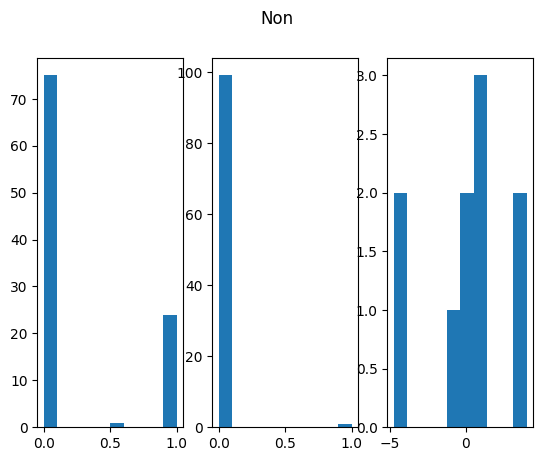

In [200]:
# Show output hidden
model_bn.eval()
out_bn = model_bn.output_hidden(train_dataset[0][0].view(-1, 28*28))
out = model.output_hidden(train_dataset[0][0].view(-1, 28*28))

fig,ax = plt.subplots(1, 3)
ax[0].hist(out_bn[0])
ax[1].hist(out_bn[1])
ax[2].hist(out_bn[2])
fig.suptitle("Batch Normalization")
plt.show()

fig,ax = plt.subplots(1, 3)
ax[0].hist(out[0])
ax[1].hist(out[1])
ax[2].hist(out[2])
fig.suptitle("Non")
plt.show()

**Nhận xét**: Biểu đồ thứ 3 là đầu ra của mạng Neural nên ko có áp Batch Norm lên ko tính. Có thể thấy dõ phân bố đầu ra của các tầng ẩn nếu dùng batch norm sẽ có phân phối chuẩn, các gía trị phân bố đều xung quanh giá trị 0.  
Ơ biểu đồ 2 có thể thấy hầu hết đâu ra của tầng ẩn có giá trị là 0. Đầu ra bằng 0 thì không học được gì với Backporation